### Import

In [ ]:
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison

## Display function

In [ ]:
#function for displaying ROC curves of multiple classifiers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_connected_points(results_list, results_original_roc, name="All Classifiers"):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by='fpr').reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c='black', marker='o', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label=f'{name} (AUC = {auc(df_sorted["fpr"], df_sorted["tpr"]):.2f})')
    
    #plot the original ROC curve
    plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', 
             label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Best ROC envelope

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve

def get_best_roc_envelope(results_list, results_original_roc=None):
    """
    Constructs the upper envelope of multiple ROC curves to find the best
    possible operating points from a collection of classifiers.

    This function is guaranteed to produce a list of points that starts at
    (FPR=0, TPR=0) and ends at (FPR=1, TPR=1), making it suitable for direct
    plotting and AUC calculation.

    Args:
        results_list (list): A list of dictionaries. Each dictionary must
                             contain a 'model' name and the full ROC results
                             under the 'full_roc' key.
        results_original_roc (dict, optional): A dictionary containing the
                                               ROC results of a baseline model,
                                               which will also be included in
                                               the comparison. Defaults to None.

    Returns:
        list: A sorted list of dictionaries representing the optimal ROC
              envelope. Each dictionary includes 'model', 'fpr', 'tpr',
              and 'threshold'.
    """
    all_points = []

    # Step 1: Gather all ROC points from all provided models
    all_results = results_list[:]
    if results_original_roc:
        all_results.append({
            'model': 'original_baseline',
            'full_roc': results_original_roc
        })

    for result in all_results:
        model_name = result.get('model', 'Unknown Model')
        roc = result.get('full_roc')
        if not roc: continue

        fprs = roc.get('fpr', [])
        tprs = roc.get('tpr', [])
        thresholds = roc.get('thresholds', [])

        for i in range(len(fprs)):
            threshold = thresholds[i] if i < len(thresholds) else thresholds[-1]
            all_points.append({
                'model': model_name, 'fpr': fprs[i],
                'tpr': tprs[i], 'threshold': threshold
            })

    # Handle case with no data by returning a default diagonal line
    if not all_points:
        return [
            {'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf},
            {'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0}
        ]

    # Step 2: Sort all points by FPR (asc), then by TPR (desc)
    all_points.sort(key=lambda p: (p['fpr'], -p['tpr']))

    # Step 3: Build the core ROC envelope
    best_roc_envelope = []
    max_tpr_so_far = -1.0
    for point in all_points:
        # Add a point only if it has a strictly higher TPR
        if point['tpr'] > max_tpr_so_far:
            # To prevent adding multiple points at the same FPR, check if the last point
            # has the same FPR and replace it if so (since this one has a higher TPR)
            if best_roc_envelope and best_roc_envelope[-1]['fpr'] == point['fpr']:
                best_roc_envelope[-1] = point
            else:
                best_roc_envelope.append(point)
            max_tpr_so_far = point['tpr']
    
    # Step 4: Manually add extremities if they are missing
    
    # Ensure the curve starts at (0, 0)
    if not best_roc_envelope or best_roc_envelope[0]['fpr'] > 0.0:
        best_roc_envelope.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if best_roc_envelope[-1]['fpr'] < 1.0 or best_roc_envelope[-1]['tpr'] < 1.0:
        best_roc_envelope.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return best_roc_envelope

## Data generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def generate_data(dataset):
    if dataset == "data1":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )

        

        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    elif dataset == "data2":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )


        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "pneumoniaMNIST":
        import medmnist
        print(medmnist.__version__)
        # read in the PneumoniaMNIST dataset
        from medmnist import PneumoniaMNIST
        train_data = PneumoniaMNIST(split='train', download=True, size=224)
        test_data = PneumoniaMNIST(split='test', download=True, size=224)
        val_data = PneumoniaMNIST(split='val', download=True, size=224)
        # print the dataset info
        print(f"Number of training samples: {len(train_data)}")
        print(f"Number of test samples: {len(test_data)}")
        print(f"Number of validation samples: {len(val_data)}")

    return train_data, test_data, val_data


## Data1: NN

In [4]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

In [5]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4
K_FOLDS = 4

### Lightning module

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import torchmetrics
import numpy as np

# A simple classifier head
class SimpleClassifier(nn.Module):
    def __init__(self, input_features=2, hidden_units=32, num_classes=1):
        """
        Args:
            input_features (int): Number of input features (2 for your data)
            hidden_units (int): Number of neurons in the hidden layer
            num_classes (int): Number of output classes (1 for binary)
        """
        super().__init__()
        self.layer_stack = nn.Sequential(
            # --- Hidden Layer 1 ---
            # Takes 2 features in, outputs a hidden representation of size 32
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),  # <-- The crucial non-linear activation function

            # --- Output Layer ---
            # Takes the 16-unit hidden representation, outputs 1 logit
            nn.Linear(in_features=hidden_units, out_features=num_classes)
        )

    def forward(self, x):
        return self.layer_stack(x)

# A new LightningModule just for training the classifier
class LitClassifier(pl.LightningModule):
    def __init__(self, input_features=512, hidden_units=32, num_classes=1, learning_rate=1e-4, pos_weight=None):
        super().__init__()
        self.save_hyperparameters()
        self.model = SimpleClassifier(
            input_features=self.hparams.input_features,
            hidden_units=self.hparams.hidden_units,
            num_classes=self.hparams.num_classes
        )

        self.current_test_threshold = 0.5  # Default threshold for binary classification

        # This ensures the model's structure is correct upon initialization
        if self.hparams.pos_weight is not None:
            self.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.hparams.pos_weight))
        else:
            self.criterion = nn.BCEWithLogitsLoss()

        
        
        # --- METRICS ---
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_auc = torchmetrics.AUROC(task="binary")
        
        # This list will store outputs from each test step
        self.test_step_outputs = []
        # This dictionary will hold the final results
        self.last_test_results = {}

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self(features)
        
        # For the loss function, labels need to be reshaped to match outputs
        loss = self.criterion(outputs, labels.float().view(-1, 1))
        
        # For metrics, squeeze predictions to match labels' shape
        self.train_accuracy(outputs.squeeze(), labels.int())
        
        self.log('classifier_train_loss', loss, on_step=False, on_epoch=True)
        self.log('classifier_train_acc', self.train_accuracy, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self.model(features)
        loss = self.criterion(outputs, labels.float().view(-1, 1))

        # Append predictions and labels to our list for aggregation
        self.test_step_outputs.append({"preds": outputs.detach(), "labels": labels.detach()})
        
        self.log('test_loss', loss)
        return {"loss": loss}

    def on_test_epoch_end(self):
        if not self.test_step_outputs:
            return # Avoid errors if test loop was empty

        # Concatenate all predictions and labels
        all_preds = torch.cat([x['preds'] for x in self.test_step_outputs])
        all_labels = torch.cat([x['labels'] for x in self.test_step_outputs])

        # --- FIX: Squeeze BOTH predictions and labels to ensure they match ---
        squeezed_preds = all_preds.squeeze()
        all_probs = torch.sigmoid(squeezed_preds)
        # The labels tensor might also be [N, 1], so we squeeze it as well.
        int_labels = all_labels.squeeze().int()

        # Calculate final scalar metrics
        test_acc = self.test_accuracy(squeezed_preds, int_labels)
        test_auc_val = self.test_auc(squeezed_preds, int_labels)


        # Get the confusion matrix stats at the default 0.0 logit threshold
        tp, fp, tn, fn, _ = torchmetrics.functional.stat_scores(
            all_probs, int_labels, task="binary", threshold=self.current_test_threshold
        ) 
        
        # Calculate TPR and FPR from these raw scores
        epsilon = 1e-6
        tpr_at_0 = tp / (tp + fn + epsilon)
        fpr_at_0 = fp / (fp + tn + epsilon)

        # Calculate data for the full ROC Curve
        fpr_full, tpr_full, thresholds_full = torchmetrics.functional.roc(
            torch.sigmoid(squeezed_preds),
            int_labels,
            task="binary"
        )




        print(f"\n--- Final Classifier Test Metrics ---")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"AUC: {test_auc_val:.4f}")
        print("-------------------------------------\n")
        
        self.last_test_results = {
            "w": self.hparams.get('w'),
            "fpr": fpr_at_0.cpu().numpy(),
            "tpr": tpr_at_0.cpu().numpy(),
            "threshold": self.current_test_threshold,
            "auc": test_auc_val.cpu().numpy(),
            "accuracy": test_acc.cpu().numpy(),
            "full_roc": {
                "fpr": fpr_full.cpu().numpy(),
                "tpr": tpr_full.cpu().numpy(),
                "thresholds": thresholds_full.cpu().numpy()
            }
        }
        self.test_step_outputs.clear()
        
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)


### Generate data

In [5]:
from sklearn.model_selection import KFold

train_data, test_data, val_data = generate_data("data1")


train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# initialize fold
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)


NameError: name 'generate_data' is not defined

### Regular training

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)




# 1. Instantiate the LightningModule
model = LitClassifier(input_features=2, hidden_units=32, learning_rate=LEARNING_RATE)

checkpoint_callback_full_model = ModelCheckpoint(
    monitor='classifier_train_acc',  # Monitor training accuracy
    every_n_epochs=1,                # Save model every epoch
    dirpath='checkpoints/',
    filename='simple-clf-{epoch:02d}',
    save_top_k=1,
    mode='max',
)

train_trainer_1 = pl.Trainer(
    accelerator='gpu',                 # Use GPUs
    devices=1,                         # Number of GPUs to use
    #strategy='ddp_notebook',                    # DistributedDataParallel strategy (best for multi-GPU)
    max_epochs=NUM_EPOCHS,              # Total number of epochs
    callbacks=[checkpoint_callback_full_model, progress_bar],
    logger=pl.loggers.TensorBoardLogger("lightning_logs/", name="simple-clf-train"),
)

test_trainer_1 = pl.Trainer(
    accelerator='gpu',
    devices=1,  # Use only one GPU
    logger = pl.loggers.TensorBoardLogger("lightning_logs/", name="simple-clf-test"),
    # Add the callback here so the Trainer can find the 'best' path
    callbacks=[checkpoint_callback_full_model],
    precision='16-mixed'  # Use mixed precision for testing
)

# --- Phase 1 Training ---
print(f"--- Starting Training for {NUM_EPOCHS} epochs on train_loader ---")
train_trainer_1.fit(model, train_dataloaders=train_loader)

# CRITICAL: Save the path to the best model from this phase
path_after_phase1 = checkpoint_callback_full_model.best_model_path
print(f"Best model from Phase 1 saved to: {path_after_phase1}")

# --- Test 1: Evaluate the model from after Phase 1 ---
print(f"\n--- Testing model from Phase 1 checkpoint: {path_after_phase1} ---")
model.current_test_title = "ROC Curve after training on DataLoader 1"
model = LitClassifier.load_from_checkpoint(path_after_phase1)  # Load the model from Phase 1
model.eval().to('cuda:0')  # Ensure the model is in evaluation mode and on GPU
test_trainer_1.test(model, dataloaders=test_loader, ckpt_path=path_after_phase1)
results_phase1 = model.last_test_results.copy()
results_original_roc = {"fpr": results_phase1["full_roc"]["fpr"], "tpr": results_phase1["full_roc"]["tpr"], "thresholds": results_phase1["full_roc"]["thresholds"], "name": "Original NN data1", "auc": results_phase1["auc"], "model": model}

# Metrics
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model.eval() # Set to evaluation mode

final_predictions = [] # This will store binary predictions (0s or 1s)
true_labels = []

print("\n--- Manually Calculating Metrics on Test Set ---")
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move input data to the same device as the model
        inputs = inputs.to(device)

        # 1. Get the raw model output (logits) and convert to probabilities
        outputs = torch.sigmoid(model(inputs))

        # 2. Convert probabilities to binary class predictions (0 or 1) using a 0.5 threshold
        preds = (outputs > 0.5).int()

        final_predictions.extend(preds.cpu().numpy().flatten())
        true_labels.extend(labels.cpu().numpy().flatten())

# Ensure they are numpy arrays for sklearn
true_labels = np.array(true_labels)
final_predictions = np.array(final_predictions)

# Now, calculate metrics using the correct binary predictions
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(true_labels, final_predictions)
print(cm)

print("\n--- Classification Report ---")
report = classification_report(true_labels, final_predictions, target_names=['Class 0', 'Class 1'], zero_division=0)
print(report)

### Oversampling ROC curve

In [ ]:
import numpy as np
from collections import Counter
# --- Configuration ---
EPSILON = 1e-9
# EXPECTED_MODES_PER_CLASS, etc. removed
# FIXED_TARGET_STD_SYNTHETIC removed

# --- Parameter for KDE-like generator ---
SIGMA_KDE_PERTURBATION = 0.1 # Adjust as needed

# --- This block generates the list of ratios for your experiment ---
def generate_ratios(train_data):
    # 1. Get original class counts from your train_dataset

    # --- Initial Data Analysis ---
    counter = Counter(train_data[:, -1])  # Assuming the last column is the class label
    Class0_initial = counter.get(0, 0)
    Class1_initial = counter.get(1, 0)


    class_ratio_low = 0.1   
    class_ratio_high = 100.0 
    num_points_below = 25 
    num_points_above = 25 

    if Class1_initial == 0 and Class0_initial == 0:
        print("ERROR: Both classes have zero samples initially. Cannot proceed.")
        alpha_target_actual_values = [] 
        current_class_ratio = 1.0
    elif Class1_initial == 0:
        current_class_ratio = np.inf 
    else:
        current_class_ratio = Class0_initial / Class1_initial

    # ... (alpha_target_actual_values generation - same robust version) ...
    alpha_target_list = []
    if Class0_initial > 0 or Class1_initial > 0: 
        if current_class_ratio > 0 and not np.isinf(current_class_ratio): 
            alpha_target_list.append(current_class_ratio)
        _safe_class_ratio_low = max(class_ratio_low, EPSILON)
        if current_class_ratio > _safe_class_ratio_low and not np.isinf(current_class_ratio): 
            try:
                alpha_b = np.geomspace(_safe_class_ratio_low, current_class_ratio, num_points_below, endpoint=False)
                alpha_target_list.extend(alpha_b)
            except ValueError: pass
        if current_class_ratio < class_ratio_high and current_class_ratio >= 0 and not np.isinf(current_class_ratio): 
            try:
                _start_geom_above = max(current_class_ratio, _safe_class_ratio_low) 
                if class_ratio_high > _start_geom_above:
                    alpha_a = np.geomspace(_start_geom_above, class_ratio_high, num_points_above, endpoint=True)
                    if not np.isclose(_start_geom_above, current_class_ratio) and current_class_ratio >=_safe_class_ratio_low and current_class_ratio <= class_ratio_high :
                        alpha_target_list.append(current_class_ratio)
                    alpha_target_list.extend(alpha_a)
                elif np.isclose(class_ratio_high, _start_geom_above):
                    alpha_target_list.append(class_ratio_high)
            except ValueError: pass
        if not alpha_target_list and (Class0_initial > 0 or Class1_initial > 0): 
            if not np.isinf(current_class_ratio) and current_class_ratio > 0:
                alpha_target_list.append(current_class_ratio)
            else: 
                alpha_target_list.extend(np.geomspace(_safe_class_ratio_low, class_ratio_high, num_points_below + num_points_above))
        alpha_target_actual_values = np.unique(alpha_target_list)
        alpha_target_actual_values = np.sort(alpha_target_actual_values[alpha_target_actual_values >= 0]) 
        alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values >= _safe_class_ratio_low] 
        alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values <= class_ratio_high]
        if not alpha_target_actual_values.size and (Class0_initial > 0 or Class1_initial > 0) : 
            if not np.isinf(current_class_ratio) and current_class_ratio > _safe_class_ratio_low and current_class_ratio < class_ratio_high:
                alpha_target_actual_values = np.array([current_class_ratio])
            else: 
                alpha_target_actual_values = np.array([(_safe_class_ratio_low + class_ratio_high)/2.0])


    print(f"INFO: Initial C0={Class0_initial}, C1={Class1_initial}, Ratio(0/1): {current_class_ratio if Class1_initial > 0 else 'N/A'}")
    print(f"INFO: Target ratios (w values): {alpha_target_actual_values}")
    print(f"INFO: KDE-like perturbation sigma: {SIGMA_KDE_PERTURBATION}")
    print(f"INFO: Standard deviation of synthetic samples will NOT be modified after generation.")

    return alpha_target_actual_values, Class0_initial, Class1_initial

In [ ]:
import numpy as np
from collections import Counter


def oversample_dataset_KDE(Class0_initial, Class1_initial, alpha_target, train_data):
    """
    Oversamples a dataset to a target ratio using a KDE-like method.
    This version contains fixes for shape errors when no samples are generated.
    """
    # --- Determine Oversampling Strategy ---
    oversampled_class_label_by_strategy = -1
    initial_count_of_oversampled_class = -1
    final_count_of_oversampled_class = -1

    if Class1_initial == 0 and Class0_initial > 0:
        current_class_ratio = np.inf
    elif Class1_initial == 0 and Class0_initial == 0:
        current_class_ratio = 1.0 # Or some other neutral value
    else:
        current_class_ratio = Class0_initial / Class1_initial

    # Decide which class to oversample or if we should do nothing
    if abs(alpha_target - current_class_ratio) < EPSILON:
        # Ratios are the same, do nothing
        initial_count_of_oversampled_class = Class1_initial # Placeholder
        final_count_of_oversampled_class = Class1_initial   # Placeholder
    elif alpha_target > current_class_ratio:
        # Target has more C0 relative to C1 -> Oversample C0
        oversampled_class_label_by_strategy = 0
        initial_count_of_oversampled_class = Class0_initial
        final_count_of_oversampled_class = int(round(Class1_initial * alpha_target))
    else: # alpha_target < current_class_ratio
        # Target has more C1 relative to C0 -> Oversample C1
        oversampled_class_label_by_strategy = 1
        initial_count_of_oversampled_class = Class1_initial
        final_count_of_oversampled_class = int(round(Class0_initial / alpha_target))

    num_synthetic_to_generate = max(0, final_count_of_oversampled_class - initial_count_of_oversampled_class)
    print(f"  INFO: Strategy: Oversample class {oversampled_class_label_by_strategy} from {initial_count_of_oversampled_class} to {final_count_of_oversampled_class} (generating {num_synthetic_to_generate} samples).")


    # --- KDE-like Synthetic Sample Generation ---
    if num_synthetic_to_generate > 0:
        print(f"  INFO: Using KDE-like generator. Perturbation sigma: {SIGMA_KDE_PERTURBATION}")
        X_new_synthetic = []
        y_new_synthetic = []

        indices_class = np.where(train_data[:, -1] == oversampled_class_label_by_strategy)[0]
        
        if len(indices_class) > 0:
            for _ in range(num_synthetic_to_generate):
                idx_star = np.random.choice(indices_class)
                X_star = train_data[idx_star, :-1]
                epsilon_noise = np.random.randn(*X_star.shape)
                X_prime = X_star + SIGMA_KDE_PERTURBATION * epsilon_noise
                X_new_synthetic.append(X_prime)
                y_new_synthetic.append(oversampled_class_label_by_strategy)

            X_new_synthetic_arr = np.array(X_new_synthetic)
            y_new_synthetic_arr = np.array(y_new_synthetic)
            X_resampled = np.vstack((train_data[:, :-1], X_new_synthetic_arr))
            y_resampled = np.concatenate((train_data[:, -1], y_new_synthetic_arr))
            resampled_counts = Counter(y_resampled)
            print(f"  INFO: KDE-like generation complete. New C0={resampled_counts.get(0,0)}, C1={resampled_counts.get(1,0)}")
        else:
             # This can happen if the class to oversample has 0 members
            print("  WARNING: Cannot generate samples for a class with 0 members. Returning original data.")
            X_resampled = train_data[:, :-1]
            y_resampled = train_data[:, -1]

    else: # num_synthetic_to_generate is 0
        print("  INFO: No synthetic samples were required or generated.")
        # --- THIS IS THE CRITICAL FIX ---
        # Correctly slice the original data instead of copying the whole array
        X_resampled = train_data[:, :-1]
        y_resampled = train_data[:, -1]
        # ----------------------------

    return X_resampled, y_resampled

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)

#store the weighted classifiers of all the folds
list_folds_weighted_clfs = []  # List to store classifiers from all folds
#store the best classfiers of all the folds
list_folds_best_models = []  # List to store best models from all folds

# Dictionary to store the history of each fold
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# 3. K-fold cross-validation loop
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data_tensor)):
    list_weighted_clfs = [] # List to store the models trained at each stage
    best_clfs = [] # List to store the best models from each stage
    best_model_paths = [] # List to store the path of the best model from each stage
    print(f"--- Starting Fold {fold + 1}/{K_FOLDS} ---")
    # 1. Instantiate the LightningModule
    model = LitClassifier(input_features=2, hidden_units=32, learning_rate=LEARNING_RATE)

    # --- Create datasets and dataloaders for the current fold ---
    # FIX 2: Get the fold-specific data by indexing the underlying tensors of the TensorDataset
    fold_train_features, fold_train_labels = train_data_tensor.tensors[0][train_ids], train_data_tensor.tensors[1][train_ids]
    fold_val_features, fold_val_labels = train_data_tensor.tensors[0][val_ids], train_data_tensor.tensors[1][val_ids]

    # Create the validation loader for this fold
    fold_val_dataset = data.TensorDataset(fold_val_features, fold_val_labels)
    fold_loader = data.DataLoader(fold_val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    # Create a temporary dataset for the generate_ratios function
    temp_train_dataset_for_ratios = np.c_[fold_train_features, fold_train_labels]
    alpha_target_actual_values, Class0_initial, Class1_initial = generate_ratios(train_data=temp_train_dataset_for_ratios)

    for w_idx, w in enumerate(alpha_target_actual_values):
        print(f"\n--- Processing target ratio w ({w_idx+1}/{len(alpha_target_actual_values)}): {w:.4f} ---")
        X_train, y_train = oversample_dataset_KDE(Class0_initial, Class1_initial, w, train_data=temp_train_dataset_for_ratios)
        # Create a new DataLoader for the current stage with the oversampled data
        oversampled_train_dataset = data.TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                                       torch.tensor(y_train, dtype=torch.float32))
        fold_train_loader = data.DataLoader(oversampled_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)  # Ensure drop_last=True for consistent batch sizes
        
        
        checkpoint_callback = ModelCheckpoint(
            every_n_epochs=1,                # Save model every epoch
            dirpath=f'checkpoints/stage_{w_idx+1}/fold_{fold+1}/',
            filename=f'best-model-fold{fold+1}-{{epoch:02d}}',
            save_top_k=1,
            mode='max',
        )
        
        # 3. Instantiate a NEW Trainer for this specific stage
        trainer = pl.Trainer(
            accelerator='gpu',
            devices=1,
            #strategy='ddp_notebook',
            max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
            callbacks=[checkpoint_callback, progress_bar],
            #logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{w_idx+1}_fold_{fold+1}_ratio_{alpha_target_actual_values}"),
            precision='16-mixed'
            )
        
        # 4. Train the model. It will start with weights from the previous stage.
        trainer.fit(model, train_dataloaders=fold_train_loader)
        
        # 5. Get the path to the best model from THIS stage and store it
        if checkpoint_callback.best_model_path:
            best_path_this_stage = checkpoint_callback.best_model_path
            print(f"--- Fold {fold+1} Stage {w_idx+1} complete. Best model path: {best_path_this_stage} ---")
            best_model_paths.append(best_path_this_stage)
            
            # 6. CRITICAL: Load the best weights back into the model object
            # This ensures we carry forward the BEST model to the next stage, not the last.
            print(f"Loading best weights from {best_path_this_stage} to continue...")
            model = LitClassifier.load_from_checkpoint(best_path_this_stage, strict=False)  # Use strict=False to ignore missing keys if any
        else:
            print(f"--- Fold {fold+1} Stage {w_idx+1} complete. No checkpoint was saved. ---")
            # If no checkpoint was saved, the model object will just have the weights from the last epoch.

        # 7. Test the model after each stage
        print(f"\n--- Testing model after Fold {fold+1} Stage {w_idx+1} ---")
        trainer.test(model, dataloaders=fold_loader, ckpt_path=best_path_this_stage)
        results_classifier = model.last_test_results.copy()
        current_model = {
            "model": model,
            "fpr": results_classifier["fpr"],
            "tpr": results_classifier["tpr"],
            "threshold": results_classifier["threshold"],
            "full_roc": results_classifier["full_roc"]
        }
        list_weighted_clfs.append(current_model)
        best_clfs = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
    list_folds_weighted_clfs.append(list_weighted_clfs)
    list_folds_best_models.append(best_clfs)




In [ ]:
from predict_ensemble_and_evaluate import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

# Save the data
save_to_pickle(list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader, filename='pickle/NN_data1_oversampling.pkl')




# Load pickle

In [7]:
from predict_ensemble_and_evaluate import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

# Load the data
list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader = load_from_pickle(filename='pickle/NN_data1_oversampling.pkl')

Data loaded successfully.


### Ensemble prediction using voting

In [8]:
import numpy as np

# --- Loop through all the FPR values to generate the ensemble ROC curve ---



results_tuple, prior_proba = predict_ensemble_and_evaluate(list_folds_best_models=list_folds_best_models,
    test_loader=test_loader)

ensemble_results_soft = results_tuple['soft_voting']
ensemble_results_hard = results_tuple['hard_voting']
misclassification_risk = results_tuple['misclassification_risk']








Creating a single ensemble from 32 models across all folds.
Extracting full dataset...
Getting predictions from all models...


## Neyman Pearson ROC curve

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np


class SklearnPyTorchWrapper:
    def __init__(self, model, epochs=10, lr=0.001):
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)

    def fit(self, X, y):
        # This method implements the PyTorch training loop
        self.model.train()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy for binary classification

        # Convert numpy data to PyTorch tensors and create a DataLoader
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=64, shuffle=True)

        for epoch in range(self.epochs):
            for inputs, labels in loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        return self

    def predict_proba(self, X):
        # This method handles prediction and formats the output like scikit-learn
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            # Get the probability of the positive class (class 1)
            prob_class_1 = self.model(X_tensor).cpu().numpy()
            # scikit-learn expects a (n_samples, 2) array with probs for both classes
            prob_class_0 = 1 - prob_class_1
            return np.hstack((prob_class_0, prob_class_1))

# --------------------------------------------------------------------
# HOW TO USE IT WITH THE NPC CODE
# --------------------------------------------------------------------



# 3. Pass the WRAPPER object to the npc function
# The npc code will call wrapped_model.fit() and wrapped_model.predict_proba()
# It doesn't know or care that a PyTorch model is running inside.

# Assuming 'npc_instance' is an object of the 'npc' class from your file
# result = npc_instance.npc(x, y, method="", model=wrapped_model, alpha=0.1)

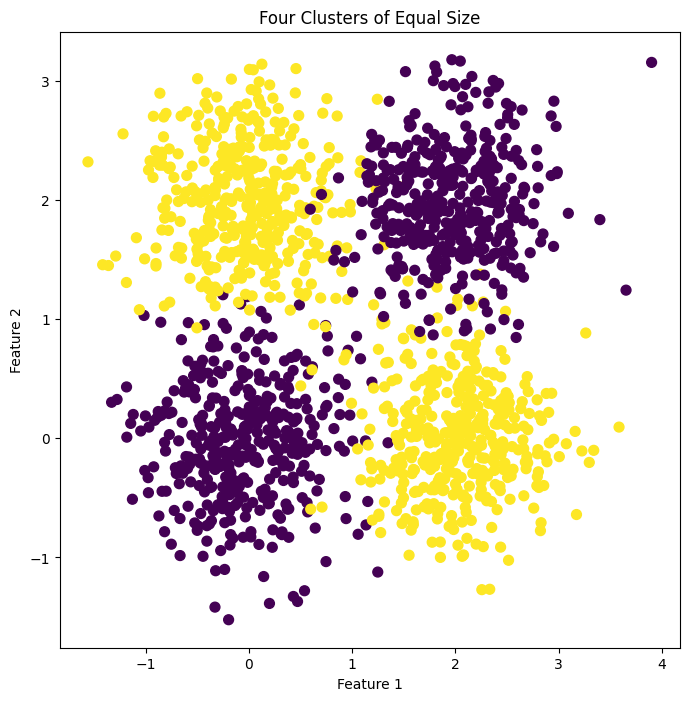

Training data shape: (1000, 2), (1000,)
Test data shape: (600, 2), (600,)
Generating constrained ROC curve (Neyman-Pearson Simulation)...
Phase 1 Complete. Model trained and scores generated.

Phase 2: Calculating cutoffs for all alphas without re-training...
Sample size is too small for the given alpha. Try a larger alpha.
Alpha 0.00 (1/51): No valid cutoff found (sample size may be too small).
Alpha 0.02 (2/51): FPR=0.007, TPR=0.243
Alpha 0.04 (3/51): FPR=0.017, TPR=0.320
Alpha 0.06 (4/51): FPR=0.063, TPR=0.390
Alpha 0.08 (5/51): FPR=0.093, TPR=0.433
Alpha 0.10 (6/51): FPR=0.100, TPR=0.457
Alpha 0.12 (7/51): FPR=0.113, TPR=0.483
Alpha 0.14 (8/51): FPR=0.127, TPR=0.493
Alpha 0.16 (9/51): FPR=0.173, TPR=0.497
Alpha 0.18 (10/51): FPR=0.187, TPR=0.503
Alpha 0.20 (11/51): FPR=0.207, TPR=0.510
Alpha 0.22 (12/51): FPR=0.230, TPR=0.510
Alpha 0.24 (13/51): FPR=0.257, TPR=0.513
Alpha 0.26 (14/51): FPR=0.270, TPR=0.513
Alpha 0.28 (15/51): FPR=0.283, TPR=0.513
Alpha 0.30 (16/51): FPR=0.297, TPR=

In [8]:
import os
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, auc
import numpy as np
import torch
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from nproc import npc
from sklearn.ensemble import RandomForestClassifier


# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4

train_data, test_data, val_data = generate_data("data1")


train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

X_train = train_data[:, :-1]
y_train = train_data[:, -1]
X_test = test_data[:, :-1]
y_test = test_data[:, -1]




print("Generating constrained ROC curve (Neyman-Pearson Simulation)...")

npc_instance = npc()

# 1. Instantiate your PyTorch model
pytorch_model = SimpleClassifier()

# 2. Create an instance of the wrapper
wrapped_model = SklearnPyTorchWrapper(model=pytorch_model, epochs=1, lr=LEARNING_RATE)

result = npc_instance.npc(
    x=X_train, 
    y=y_train, 
    method="", # Leave blank to use the provided model
    model=wrapped_model
)

# Extract the essential, one-time results
# The structure is result[fits][split_index][element_index]
fit_results = result[0][0]
final_model = fit_results[0]  # The trained PyTorch model
y_test_calib = fit_results[1]       # The labels from the calibration set
y_decision_values = fit_results[2]  # The scores from the single trained model
initial_sign = fit_results[4]       # The sign indicating score direction

print("Phase 1 Complete. Model trained and scores generated.")

# --- 3. Phase 2: Calculate All ROC Points Efficiently ---
print("\nPhase 2: Calculating cutoffs for all alphas without re-training...")

# Define the FPR constraints (alphas) we want to target
alphas = np.linspace(0, 1, 51)
roc_points = []

# predict on test data
y_test_scores = final_model.predict_proba(X_test)[:, 1]  #

# If the sign is True, it means lower scores are better for class 1.
# The npc_core function expects higher scores to be better, so we invert them once.
if initial_sign:
    y_decision_values = -y_decision_values

for i, alpha in enumerate(alphas):
    # Call ONLY the fast npc_core function
    core_result = npc_instance.npc_core(
        y_test=y_test_calib,
        y_decision_values=y_decision_values,
        alpha=alpha,
        delta=0.05,
        n_cores=1
    )
    
    if not core_result or core_result[6] == True: # core_result[6] is n_small flag
        print(f"Alpha {alpha:.2f} ({i+1}/{len(alphas)}): No valid cutoff found (sample size may be too small).")
        continue

    # Get the optimal cutoff for this specific alpha
    cutoff = core_result[0]


    # Manually apply the cutoff to the saved scores to get predictions
    # Note: We already handled the sign, so higher score is always better here.
    y_pred = (y_test_scores >= cutoff).astype(int)

    # Calculate TPR and FPR for this point
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    current_fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    current_tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    roc_points.append({'fpr': current_fpr, 'tpr': current_tpr})
    print(f"Alpha {alpha:.2f} ({i+1}/{len(alphas)}): FPR={current_fpr:.3f}, TPR={current_tpr:.3f}")

# --- 4. Process and Plot the Results ---
# Remove duplicate points
unique_points_dict = {(p['fpr'], p['tpr']): p for p in roc_points}
constrained_points = list(unique_points_dict.values())
constrained_points = sorted(constrained_points, key=lambda x: x['fpr'])

In [9]:
from predict_ensemble_and_evaluate import save_to_pickle_constrained_roc

# Save the constrained ROC curve results
save_to_pickle_constrained_roc(constrained_points, filename='pickle/NN_Data1_NP_roc_curve.pkl')

Constrained ROC curve points saved to pickle/NN_Data1_NP_roc_curve.pkl


## Load NP curve pickle

In [9]:
from predict_ensemble_and_evaluate import load_from_pickle_constrained_roc

# Load the constrained ROC curve results
constrained_points = load_from_pickle_constrained_roc(filename='pickle/NN_Data1_NP_roc_curve.pkl')

Constrained ROC curve points loaded from pickle/NN_Data1_NP_roc_curve.pkl



--- Plotting all ROC curves for comparison ---


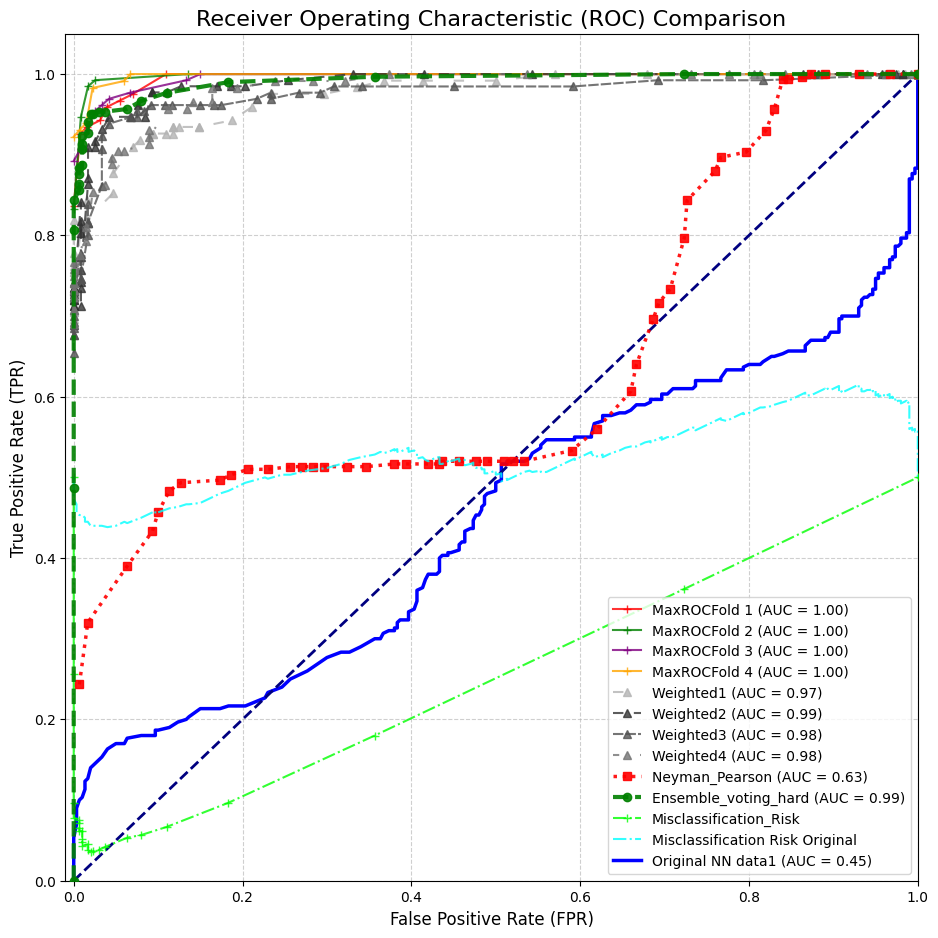

In [10]:

# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
results_lists.append(constrained_points)
results_lists.append(ensemble_results_hard)
results_lists.append(misclassification_risk)


# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    names=["MaxROCFold 1", "MaxROCFold 2", "MaxROCFold 3", "MaxROCFold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Neyman_Pearson", "Ensemble_voting_hard", "Misclassification_Risk"],
    results_original_roc=results_original_roc, plot_name="NN_oversample_data1", prior_prob=prior_proba
)